In [6]:
import pandas as pd
import os

folder_path = '/kaggle/input/datasets/alvishaflorineveigas/nasa-rul/cleaned_dataset/data'

data_list = []

for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(folder_path, file))
        df['unit_id'] = file.replace('.csv','')
        data_list.append(df)

data = pd.concat(data_list, ignore_index=True)

print("Full dataset shape:", data.shape)
data.head()

Full dataset shape: (7376834, 14)


,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time,unit_id,Current_charge,Voltage_charge,Sense_current,Battery_current,Current_ratio,Battery_impedance,Rectified_Impedance
0,4.199816,-0.001737,24.562094,0.0004,0.000,0.000,02421,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.199750,-0.000131,24.559681,0.0006,4.215,9.343,02421,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.488788,-4.025638,24.711830,3.9950,1.541,19.671,02421,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.450743,-4.023731,25.173478,3.9950,1.513,29.171,02421,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.420290,-4.023544,25.733040,3.9950,1.487,38.750,02421,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data_sample = data.sample(n=10000, random_state=42)

print("Sample shape:", data_sample.shape)

Sample shape: (10000, 14)


In [10]:
rul = data_sample.groupby('unit_id')['Time'].max().reset_index()
rul.columns = ['unit_id', 'max_time']

data_sample = data_sample.merge(rul, on='unit_id', how='left')

data_sample['RUL'] = data_sample['max_time'] - data_sample['Time']

In [13]:
X = data_sample.drop(['unit_id','Time','max_time','RUL'], axis=1)
y = data_sample['RUL']

# convert to numeric
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)

# drop problematic columns
X = X.drop(['Battery_impedance','Rectified_Impedance'], axis=1, errors='ignore')

y = pd.to_numeric(y, errors='coerce').fillna(0)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=50)  # reduced trees → faster
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50)

In [16]:
from sklearn.metrics import mean_absolute_error, r2_score

pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("R2 Score:", r2_score(y_test, pred))

MAE: 1491.44804685
R2 Score: 0.543465047497076


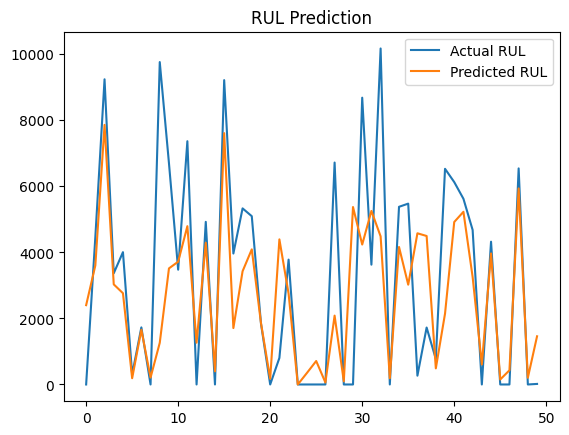

In [17]:
import matplotlib.pyplot as plt

plt.plot(y_test.values[:50], label='Actual RUL')
plt.plot(pred[:50], label='Predicted RUL')

plt.legend()
plt.title("RUL Prediction")
plt.show()

In [19]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

In [20]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

pred_dt = dt.predict(X_test)

In [21]:
from sklearn.metrics import mean_absolute_error, r2_score

print("Random Forest MAE:", mean_absolute_error(y_test, pred))
print("Random Forest R2:", r2_score(y_test, pred))

print("Linear Regression MAE:", mean_absolute_error(y_test, pred_lr))
print("Linear Regression R2:", r2_score(y_test, pred_lr))

print("Decision Tree MAE:", mean_absolute_error(y_test, pred_dt))
print("Decision Tree R2:", r2_score(y_test, pred_dt))

Random Forest MAE: 1491.44804685
Random Forest R2: 0.543465047497076
Linear Regression MAE: 1676.4928688400196
Linear Regression R2: 0.5234540457092869
Decision Tree MAE: 1827.8507155000002
Decision Tree R2: 0.17385780967738018


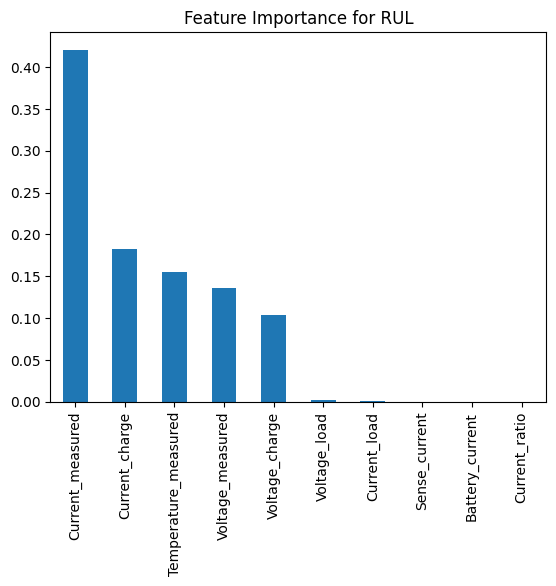

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

importance = pd.Series(model.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).plot(kind='bar')

plt.title("Feature Importance for RUL")
plt.show()

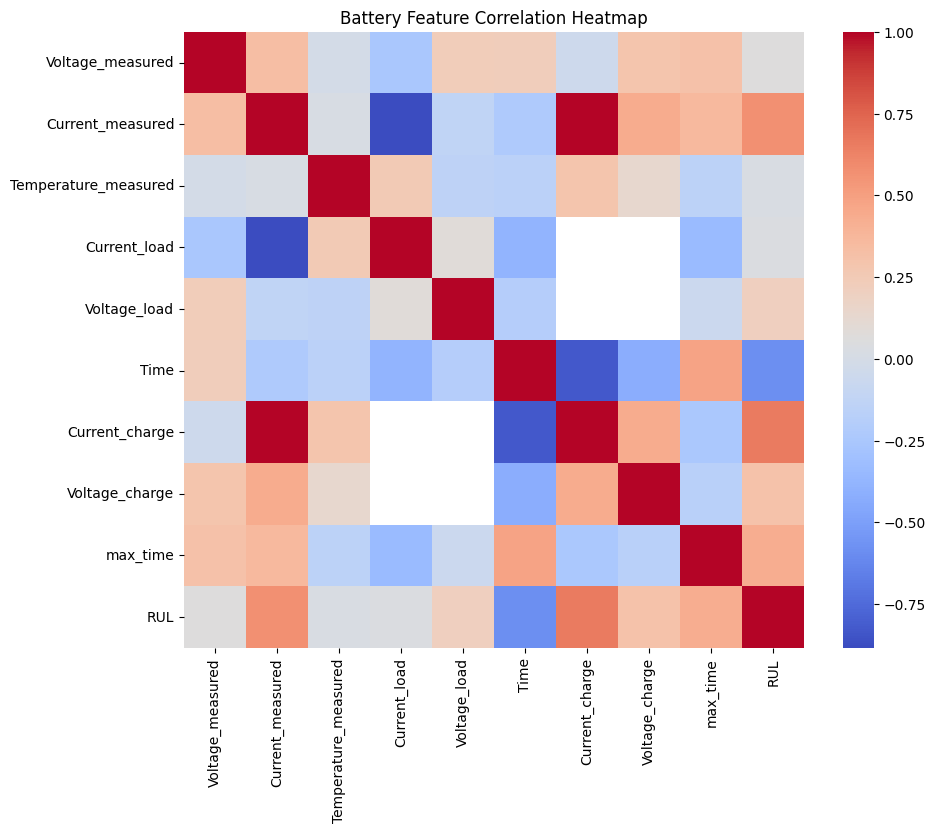

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_data = data_sample.select_dtypes(include=['number'])

plt.figure(figsize=(10,8))
sns.heatmap(numeric_data.corr(), cmap='coolwarm', annot=False)

plt.title("Battery Feature Correlation Heatmap")
plt.show()

In [27]:
print(X.columns)

Index(['Voltage_measured', 'Current_measured', 'Temperature_measured',
       'Current_load', 'Voltage_load', 'Current_charge', 'Voltage_charge',
       'Sense_current', 'Battery_current', 'Current_ratio'],
      dtype='object')


In [29]:
import pandas as pd
import numpy as np

# take input
voltage = float(input("Enter Voltage: "))
current = float(input("Enter Current: "))
temp = float(input("Enter Temperature: "))

# IMPORTANT: match EXACT columns used in training
sample_df = pd.DataFrame([{
    'Voltage_measured': voltage,
    'Current_measured': current,
    'Temperature_measured': temp,
    'Current_load': 1.0,
    'Voltage_load': 3.5,
    'Sense_current': 1.0,
    'Battery_current': 1.0,
    'Current_ratio': 1.0,
    'Current_charge': 1.1,
    'Voltage_charge': 3.8
}])

# ensure order is exactly same as training
sample_df = sample_df[X.columns]

# convert to numeric
sample_df = sample_df.apply(pd.to_numeric, errors='coerce').fillna(0)

# predict
pred = model.predict(sample_df)

print("Predicted RUL:", pred[0])

Enter Voltage:  12
Enter Current:  5
Enter Temperature:  5


Predicted RUL: 5638.189700000002
